### Load packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.coordinates import SkyCoord
from astropy.visualization.wcsaxes import SphericalCircle
import astropy.units as u

from scipy.interpolate import interp1d

import os
import glob

/home/elismar/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/elismar/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=71, Om0=0.27, Tcmb0=2.725)

In [3]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc, rcParams
f = 0.8

fontsize = 35 * f
labelsize = 35 * f

rc("xtick", labelsize=fontsize * f)
rc("ytick", labelsize=fontsize * f)
rcParams["axes.linewidth"] = 5.3 * f
rcParams["xtick.major.width"] = 5.3 * f
rcParams["xtick.minor.width"] = 5.3 * f
rcParams["ytick.major.width"] = 5.3 * f
rcParams["ytick.minor.width"] = 5.3 * f
rcParams["xtick.major.size"] = 12.5 * f
rcParams["xtick.minor.size"] = 6.5 * f
rcParams["ytick.major.size"] = 12.5 * f
rcParams["ytick.minor.size"] = 6.5 * f

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 50 * f,
        }


cm1 = plt.cm.get_cmap('jet')
cm2 = plt.cm.get_cmap('rainbow')
cm3 = plt.cm.get_cmap('gnuplot2')

color_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
colors1 = [cm1(value) for value in color_values]
colors3 = [cm3(value) for value in color_values]

## Familiarization with data

### Define cluster data

In [4]:
#Information based on the table of the paper draft (https://www.overleaf.com/4958173787sbwbtsgjzbch#c79586)

cl_names = np.array(["Abell 168", "MKW4"])
cl_ra = np.array([18.740487, 180.988406])
cl_dec = np.array([0.437564, 1.888278])
cl_z = np.array([0.044596, 0.0205])
cl_radii_kpc = np.array([0.869956, 0.882308])*1000 #kpc

#Eu mudei levement o valor do redshift de MKW4 em relação ao que tava na tabela do paper, de 0.02 para 0.0205, para se adequar melhor ao pico dos redshifts das galáxias no aglomerado

In [5]:
cl_radii_deg = []
for zi, i in zip(cl_z, range(len(cl_z))):
    kpc_scale = cosmo.kpc_proper_per_arcmin(z=zi).value/60.
    radius_deg = cl_radii_kpc[i] / (kpc_scale * 3600) #Convert radius from kpc to deg
    cl_radii_deg.append(radius_deg)
    
cl_radii_deg = np.asarray(cl_radii_deg)

In [6]:
cluster = 1

radius_cluster = cl_radii_deg[cluster]
z_cluster = cl_z[cluster]
ra0 = cl_ra[cluster]
dec0 = cl_dec[cluster]

### Legacy

In [ ]:
table_path_a168_legacy = "tables/A168+leg.parquet"
table_path_mkw4_legacy = "tables/mkw4.parquet"

In [ ]:
table_a168_legacy = pd.read_parquet(table_path_a168_legacy)
table_mkw4_legacy = pd.read_parquet(table_path_mkw4_legacy)

In [ ]:
table_mkw4_legacy.to_csv("tables/mkw4_legacy.csv", index=False)

In [8]:
table_a168_legacy = pd.read_csv("tables/A168_legacy.csv", usecols=["ra", "dec", "type", "mag_r"])
table_mkw4_legacy = pd.read_csv("tables/mkw4_legacy.csv", usecols=["ra", "dec", "type", "mag_r"])

In [9]:
ra_a168_legacy = table_a168_legacy["ra"]
dec_a168_legacy = table_a168_legacy["dec"]
type_a168_legacy = table_a168_legacy["type"]
mag_r_a168_legacy = table_a168_legacy["mag_r"]

ra_mkw4_legacy = table_mkw4_legacy["ra"]
dec_mkw4_legacy = table_mkw4_legacy["dec"]
type_mkw4_legacy = table_mkw4_legacy["type"]
mag_r_mkw4_legacy = table_mkw4_legacy["mag_r"]

In [10]:
mask_galaxies_a168 = (type_a168_legacy != "PSF") & (type_a168_legacy != "DUP")
mask_galaxies_mkw4 = (type_mkw4_legacy != "PSF") & (type_mkw4_legacy != "DUP")

/tmp/ipykernel_283836/48623749.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout(pad=3.0)
/home/elismar/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


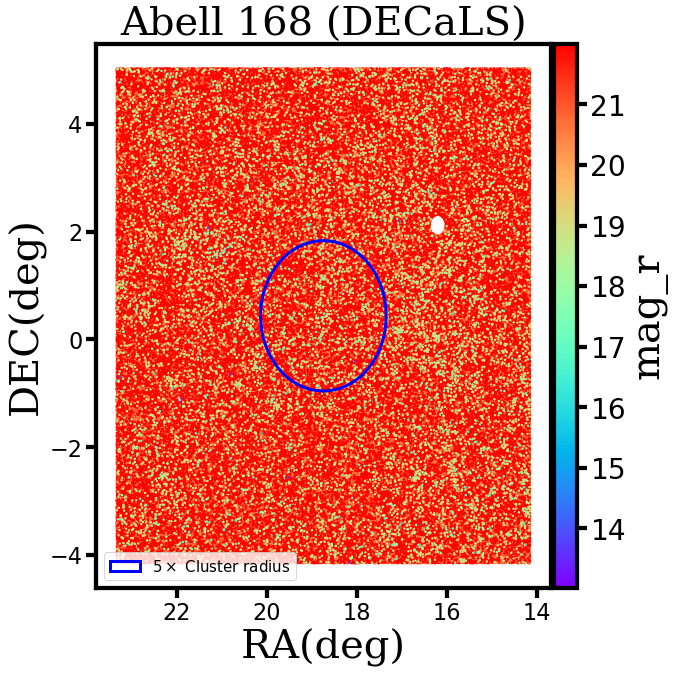

In [11]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111)
sc1 = ax1.scatter(ra_a168_legacy[mask_galaxies_a168], dec_a168_legacy[mask_galaxies_a168], 
            marker='o', c=mag_r_a168_legacy[mask_galaxies_a168], cmap=cm2, s=2)
# ax1.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center")
ax1.set_xlabel('RA(deg)',fontdict=font)
ax1.set_ylabel('DEC(deg)',fontdict=font)
ax1.invert_xaxis()
ax1.set_title("Abell 168 (DECaLS)", fontdict=font)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="mag_r", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')
r = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="blue", facecolor="None")
ax1.add_patch(r)

ax1.legend(fontsize=15)

fig.tight_layout(pad=3.0)

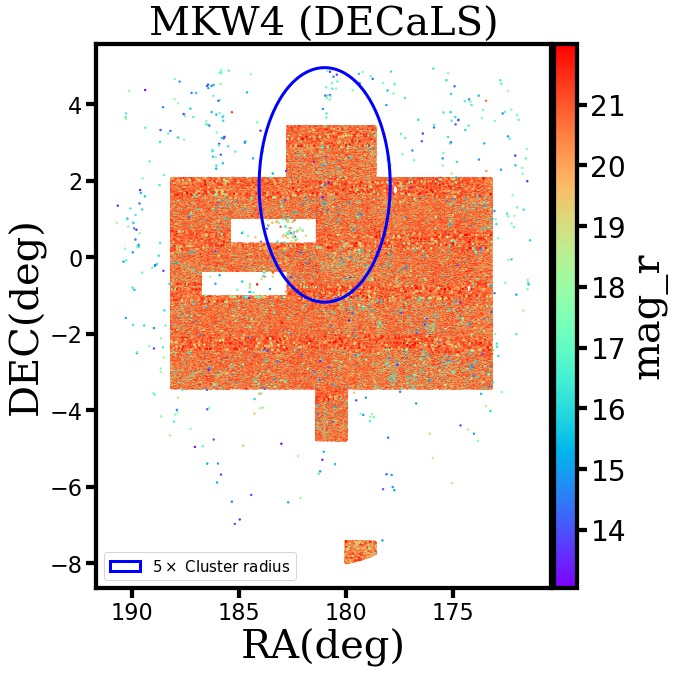

In [14]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111)
sc1 = ax1.scatter(ra_mkw4_legacy[mask_galaxies_mkw4], dec_mkw4_legacy[mask_galaxies_mkw4], 
            marker='o', c=mag_r_mkw4_legacy[mask_galaxies_mkw4], cmap=cm2, s=2)
# ax1.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center")
ax1.set_xlabel('RA(deg)',fontdict=font)
ax1.set_ylabel('DEC(deg)',fontdict=font)
ax1.invert_xaxis()
ax1.set_title("MKW4 (DECaLS)", fontdict=font)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="mag_r", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')
r = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="blue", facecolor="None")
ax1.add_patch(r)

ax1.legend(fontsize=15)

fig.tight_layout(pad=3.0)

## S-PLUS

### Concatenating tables from Erik

In [106]:
#Concatenate the data from the clusters that Erik sent
#There are tables that end with "_predicted" and others that don't. The second are the ones that contain information about the borders (I imagine this means that they have the flag to remove
#duplicated objects in the borders of S-PLUS)

fields_dir = "tables/a168/"
os.chdir(fields_dir)
cwd = os.getcwd()
fields = os.listdir(cwd)

os.chdir("../../")
os.getcwd()

'/work/Doc/galaxy-cluster-membership'

In [107]:
csv_files = np.array(glob.glob(fields_dir + "*.csv")).tolist()
df_list = (pd.read_csv(file) for file in csv_files)
big_df = pd.concat(df_list, ignore_index=True)

In [108]:
big_df.to_csv("tables/a168_additional_columns.csv", index=False)

In [ ]:
mask_fields = np.isin(glob.glob(fields_dir + "*.csv") , glob.glob(fields_dir + "*_predicted.csv"))

csv_files_predicted = glob.glob(fields_dir + "*_predicted.csv") 
df_list_predicted = (pd.read_csv(file) for file in csv_files_predicted)
big_df_predicted = pd.concat(df_list_predicted, ignore_index=True)

csv_files = np.array(glob.glob(fields_dir + "*.csv"))[~mask_fields].tolist()
df_list = (pd.read_csv(file) for file in csv_files)
big_df = pd.concat(df_list, ignore_index=True)

In [ ]:
big_df_predicted.to_csv("tables/mkw4_predicted.csv", index=False)
big_df.to_csv("tables/mkw4.csv", index=False)

### Loading tables

In [44]:
table_path_a168_splus = "tables/A168_splus_rPStotal.csv"

table_path_mkw4_splus = "tables/mkw4_splus_rPStotal.csv"

In [45]:
table_a168_splus = pd.read_csv(table_path_a168_splus, usecols=["ID", "RA", "DEC", "zml", "r_PStotal", "remove_flag"])

table_mkw4_splus = pd.read_csv(table_path_mkw4_splus, usecols=["ID", "RA", "DEC", "zml", "r_PStotal", "remove_flag"])

In [55]:
table_mkw4_splus["ID"].str[7:-8].unique()

array(['SPLUS-n02n21', 'SPLUS-n01s23', 'SPLUS-n02n23', 'SPLUS-n01s22',
       'SPLUS-n01s25', 'SPLUS-n01s21', 'SPLUS-n02n25', 'SPLUS-n01s24',
       'SPLUS-n02n22', 'SPLUS-n02s23', 'SPLUS-n02s24', 'SPLUS-n02s22',
       'SPLUS-n02n24'], dtype=object)

In [17]:
ra_a168_splus = table_a168_splus["RA"]
dec_a168_splus = table_a168_splus["DEC"]
zml_a168_splus = table_a168_splus["zml"]
rpstotal_a168_splus = table_a168_splus["r_PStotal"]
remove_flag_a168_splus = table_a168_splus["remove_flag"]

ra_mkw4_splus = table_mkw4_splus["RA"]
dec_mkw4_splus = table_mkw4_splus["DEC"]
zml_mkw4_splus = table_mkw4_splus["zml"]
rpstotal_mkw4_splus = table_mkw4_splus["r_PStotal"]
remove_flag_mkw4_splus = table_mkw4_splus["remove_flag"]

In [18]:
mask_splus_a168 = (remove_flag_a168_splus == False) & (rpstotal_a168_splus < 90)

mask_splus_mkw4 = (remove_flag_mkw4_splus == False) & (rpstotal_mkw4_splus < 90)

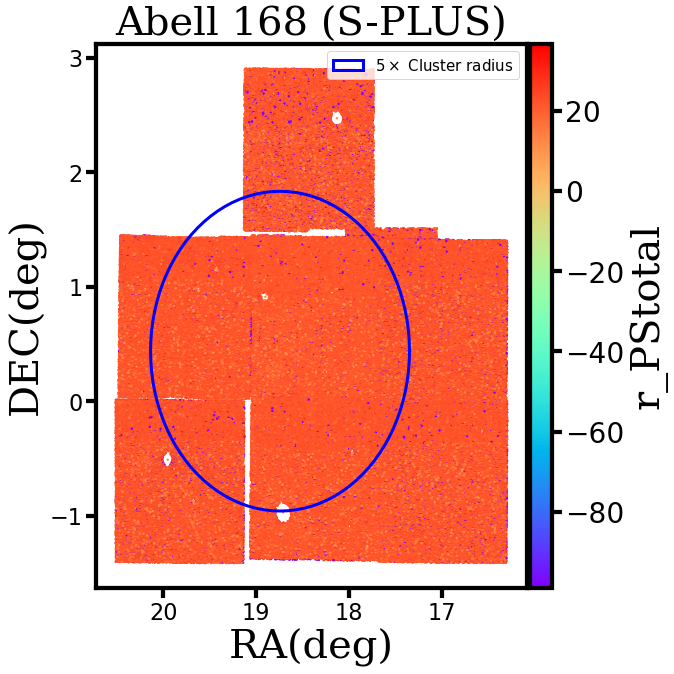

In [23]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111)
sc1 = ax1.scatter(ra_a168_splus[mask_splus_a168], dec_a168_splus[mask_splus_a168], 
            marker='o', c=rpstotal_a168_splus[mask_splus_a168], cmap=cm2, s=2)
# ax1.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center")
ax1.set_xlabel('RA(deg)',fontdict=font)
ax1.set_ylabel('DEC(deg)',fontdict=font)
ax1.invert_xaxis()
ax1.set_title("Abell 168 (S-PLUS)", fontdict=font)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="r_PStotal", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')
r = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="blue", facecolor="None")
ax1.add_patch(r)

ax1.legend(fontsize=15)

fig.tight_layout(pad=3.0)

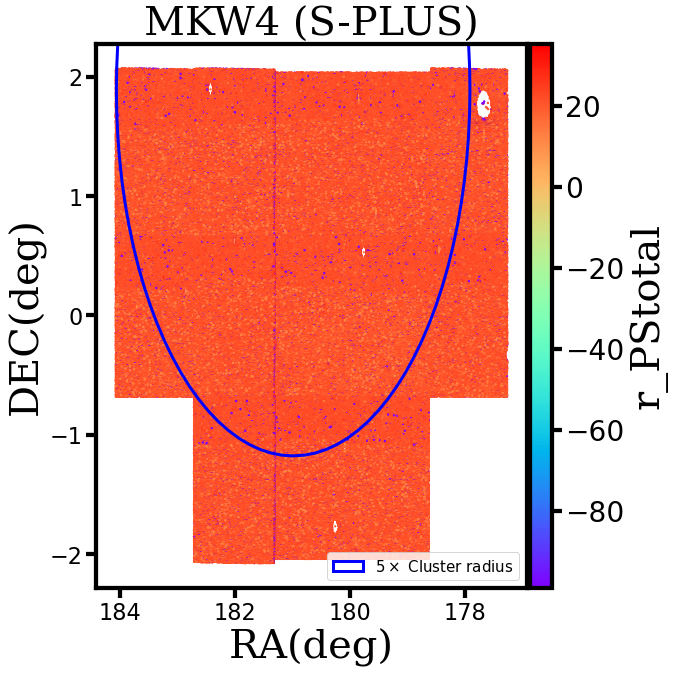

In [21]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111)
sc1 = ax1.scatter(ra_mkw4_splus[mask_splus_mkw4], dec_mkw4_splus[mask_splus_mkw4], 
            marker='o', c=rpstotal_mkw4_splus[mask_splus_mkw4], cmap=cm2, s=2)
# ax1.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center")
ax1.set_xlabel('RA(deg)',fontdict=font)
ax1.set_ylabel('DEC(deg)',fontdict=font)
ax1.invert_xaxis()
ax1.set_title("MKW4 (S-PLUS)", fontdict=font)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="r_PStotal", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')
r = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="blue", facecolor="None")
ax1.add_patch(r)

ax1.legend(fontsize=15)

fig.tight_layout(pad=3.0)

I crossmatched S-PLUS and Legacy tables on TOPCAT, using 2 arcsecs for the crossmatch radius. Table names:

 - "a168_legacy_splus_rPStotal_crossmatch.csv"
 - "mkw4_legacy_splus_rPStotal_crossmatch.csv"
 
 We also have to do a crossmatch with the Spectroscopic_Catalogue (I used 2 arcsecs as well). Resulting table names:
 
 - "a168_legacy_splus_rPStotal_specz_crossmatch.csv"
 - "mkw4_legacy_splus_rPStotal_specz_crossmatch.csv"

In [7]:
#Por enquanto estou usando o r_aper_6, mas é porque só tenho r_aper_3 e r_aper_6 nessa tabela do A168.
col_names = ['ID', 'RA_1', 'DEC_1', 'zml', 'pdf_weights_0', 'pdf_weights_1', 'pdf_weights_2', 'pdf_means_0',
       'pdf_means_1', 'pdf_means_2', 'pdf_stds_0', 'pdf_stds_1', 'pdf_stds_2', 'r_PStotal', "r_petro", "r_aper_6"]

In [8]:
if cl_names[cluster] == "Abell 168":
    t = pd.read_csv("tables/a168_legacy_splus_rPStotal_crossmatch.csv", usecols=col_names)
    t_specz = pd.read_csv("tables/a168_legacy_splus_rPStotal_specz_crossmatch.csv", usecols=col_names+["z"])
    
if cl_names[cluster] == "MKW4":
    t = pd.read_csv("tables/mkw4_legacy_splus_rPStotal_crossmatch.csv")
    t_specz = pd.read_csv("tables/mkw4_legacy_splus_rPStotal_specz_crossmatch.csv", usecols=col_names+["z"])

print("Loading data for cluster {}".format(cl_names[cluster]))
print("Cluster redshift: {:.4f}".format(z_cluster))
print("Cluster radius: {:.2f} Kpc".format(cl_radii_kpc[cluster]))
    
objid = np.asarray(t["ID"])
ra = np.asarray(t["RA_1"])
dec = np.asarray(t["DEC_1"])
zml = np.asarray(t["zml"])
pdf_weights = np.array([t[col_name] for col_name in ["pdf_weights_" + str(i) for i in range(0, 3)]])
pdf_means = np.array([t[col_name] for col_name in ["pdf_means_" + str(i) for i in range(0, 3)]])
pdf_stds = np.array([t[col_name] for col_name in ["pdf_stds_" + str(i) for i in range(0, 3)]])
rpstotal = np.asarray(t["r_PStotal"])

objid_specz = np.asarray(t_specz["ID"])
ra_specz = np.asarray(t_specz["RA_1"])
dec_specz = np.asarray(t_specz["DEC_1"])
zml_specz = np.asarray(t_specz["zml"])
pdf_weights_specz = np.array([t_specz[col_name] for col_name in ["pdf_weights_" + str(i) for i in range(0, 3)]])
pdf_means_specz = np.array([t_specz[col_name] for col_name in ["pdf_means_" + str(i) for i in range(0, 3)]])
pdf_stds_specz = np.array([t_specz[col_name] for col_name in ["pdf_stds_" + str(i) for i in range(0, 3)]])
rpstotal_specz = np.asarray(t_specz["r_PStotal"])
z = np.asarray(t_specz["z"])

Loading data for cluster MKW4
Cluster redshift: 0.0205
Cluster radius: 882.31 Kpc


## Perform the membership

[ 1.21154796e-05  4.39319909e-04 -2.11420409e-02  1.77834331e-01]


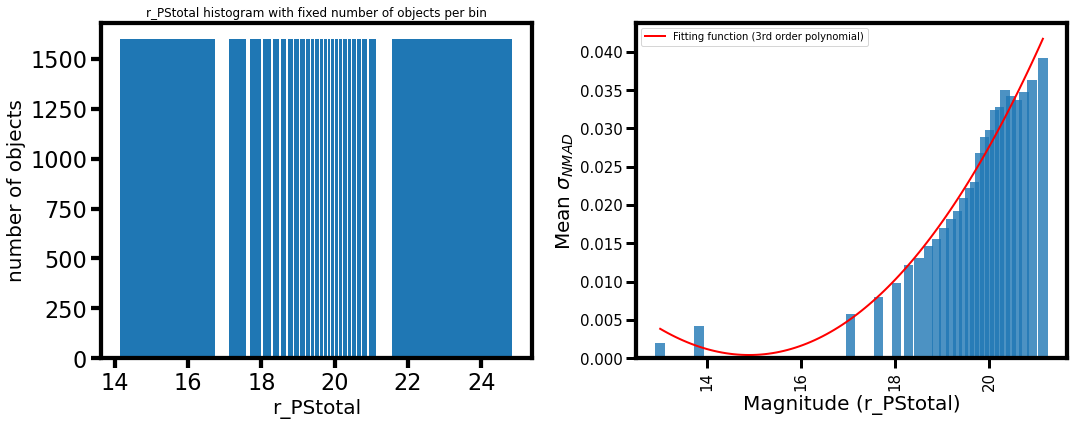

In [9]:
from galaxy_cluster_membership import *

#### O valor máximo no qual os photo-zs são bons, de acordo com o próprio Erik, é ~0.7
- Isso significa que eu só devo usar galáxias até mais ou menos 0.7 em photo-z
- E principalmente, que eu só vou definir o volume do campo até photo-z 0.7

In [10]:
#I define a range of spectroscopic redshifts previously to the application of the membership to diminish the numer
#of objects in the computation. We have to apply a safe margin to not eliminate potential cluster members

#redshift_range de 0.1 é o dobro do valor do sigma_nmad em magnitudes r ~21, então já tá mais que bom.

redshift_range = 0.7
mask_redshift = (zml > (z_cluster - redshift_range)) & (zml < (z_cluster + redshift_range))
mask_redshift_specz = (zml_specz > (z_cluster - redshift_range)) & (zml_specz < (z_cluster + redshift_range))


#Em alguns aglomerados dá pra definir desse jeito mais "automático", mas em alguns o sigma_clipping não funciona direito quando eu seto o z_lower e z_upper desse jeito.
#Por exemplo, pode ser que eu acabe selecionando um intervalo muito grande de redshifts e aí o sigma_clipping não funciona bem em alguns aglomerados
#Então nesses casos tenho que ajustar uns valores aqui à mão.
# z_lower = z_cluster-3*sigma
# z_upper = z_cluster+3*sigma

#Values for Abell 168:
# z_lower = 0.035
# z_upper = 0.055

#Values for MKW4:
z_lower = 0.01
z_upper = 0.03

### Inspecting the clusters (spectroscopic)

In [11]:
sep_specz = clustercentric_distance(ra_specz[mask_redshift_specz], dec_specz[mask_redshift_specz], 
                                    ra0, dec0)

In [12]:
sigma_z_specz = np.array([sigma_nmad(r) for r in rpstotal_specz[mask_redshift_specz]])

#This mask defines all galaxies in the 5R200 projected area of the cluster
mask_cluster_region_specz = sep_specz < 5*radius_cluster

#This one restricts the above mask to only the galaxies delimited by +/-3*sigma from the cluster redshift, defining a list of candidate members
f = 1.0
mask_cluster_specz = mask_cluster_region_specz & (zml_specz[mask_redshift_specz] > z_cluster - f*sigma_z_specz) & (zml_specz[mask_redshift_specz] < z_cluster + f*sigma_z_specz)

#This sigma_specz I apply to define the cluster's gaussian width in the membership method I think
sigma_z_specz = np.array([sigma_nmad(r) for r in rpstotal_specz[mask_redshift_specz][mask_cluster_specz]])
sigma_specz = np.median(sigma_z_specz)

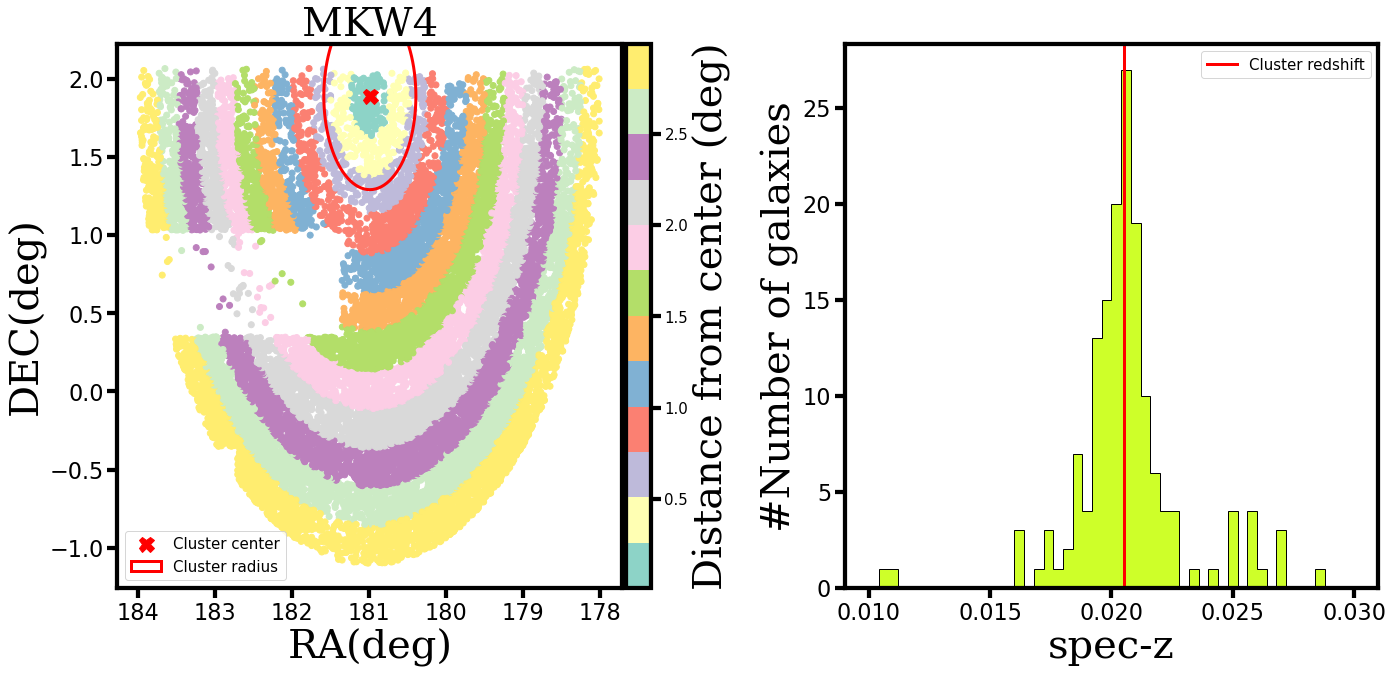

In [13]:
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121)
sc1 = ax1.scatter(ra_specz[mask_redshift_specz][mask_cluster_region_specz], 
                  dec_specz[mask_redshift_specz][mask_cluster_region_specz], 
                  marker='o', c=sep_specz[mask_cluster_region_specz], cmap=cm.Set3, rasterized=True)
ax1.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center")
ax1.set_xlabel('RA(deg)',fontdict=font)
ax1.set_ylabel('DEC(deg)',fontdict=font)
ax1.invert_xaxis()
ax1.set_title(cl_names[cluster], fontdict=font)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Distance from center (deg)", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')
r = SphericalCircle(c0, radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax1.add_patch(r)

ax1.legend(fontsize=labelsize)


ax2 = fig.add_subplot(122)
ax2.hist(z[mask_redshift_specz][mask_cluster_specz], bins=50, color=colors1[5], histtype='stepfilled', edgecolor='k', 
                 range=[z_lower, z_upper])
ax2.set_xlabel('spec-z',fontdict=font)
ax2.set_ylabel('#Number of galaxies',fontdict=font)
ax2.axvline(z_cluster, color="red", lw=3, label="Cluster redshift")

ax2.legend(fontsize=labelsize)


fig.tight_layout(pad=3.0)

# plt.savefig("../figures/clusters-membership/RA_DEC_z_distribution_{}.png".format(cl_names[cluster]), dpi='figure', format='png')

### Inspecting the clusters (photometric)

In [36]:
sep_all = clustercentric_distance(ra[mask_redshift], dec[mask_redshift], ra0, dec0)

In [37]:
sigma_z = np.array([sigma_nmad(r) for r in rpstotal[mask_redshift]])

#This mask defines all galaxies in the 5R200 projected area of the cluster
mask_cluster_region = sep_all < 5*radius_cluster

#This one restricts the above mask to only the galaxies delimited by +/-3*sigma from the cluster redshift, defining a list of candidate members
#For the sake of curiosity, these would be galaxies we would select for CHANCES with a 3*sigma_nmad criterium. 
mask_cluster = mask_cluster_region & (zml[mask_redshift] > z_cluster - f*sigma_z) & (zml[mask_redshift] < z_cluster + f*sigma_z)

# sigma_z = np.array([sigma_nmad(r) for r in rpstotal[mask_redshift][mask_cluster]])
# sigma = np.median(sigma_z)

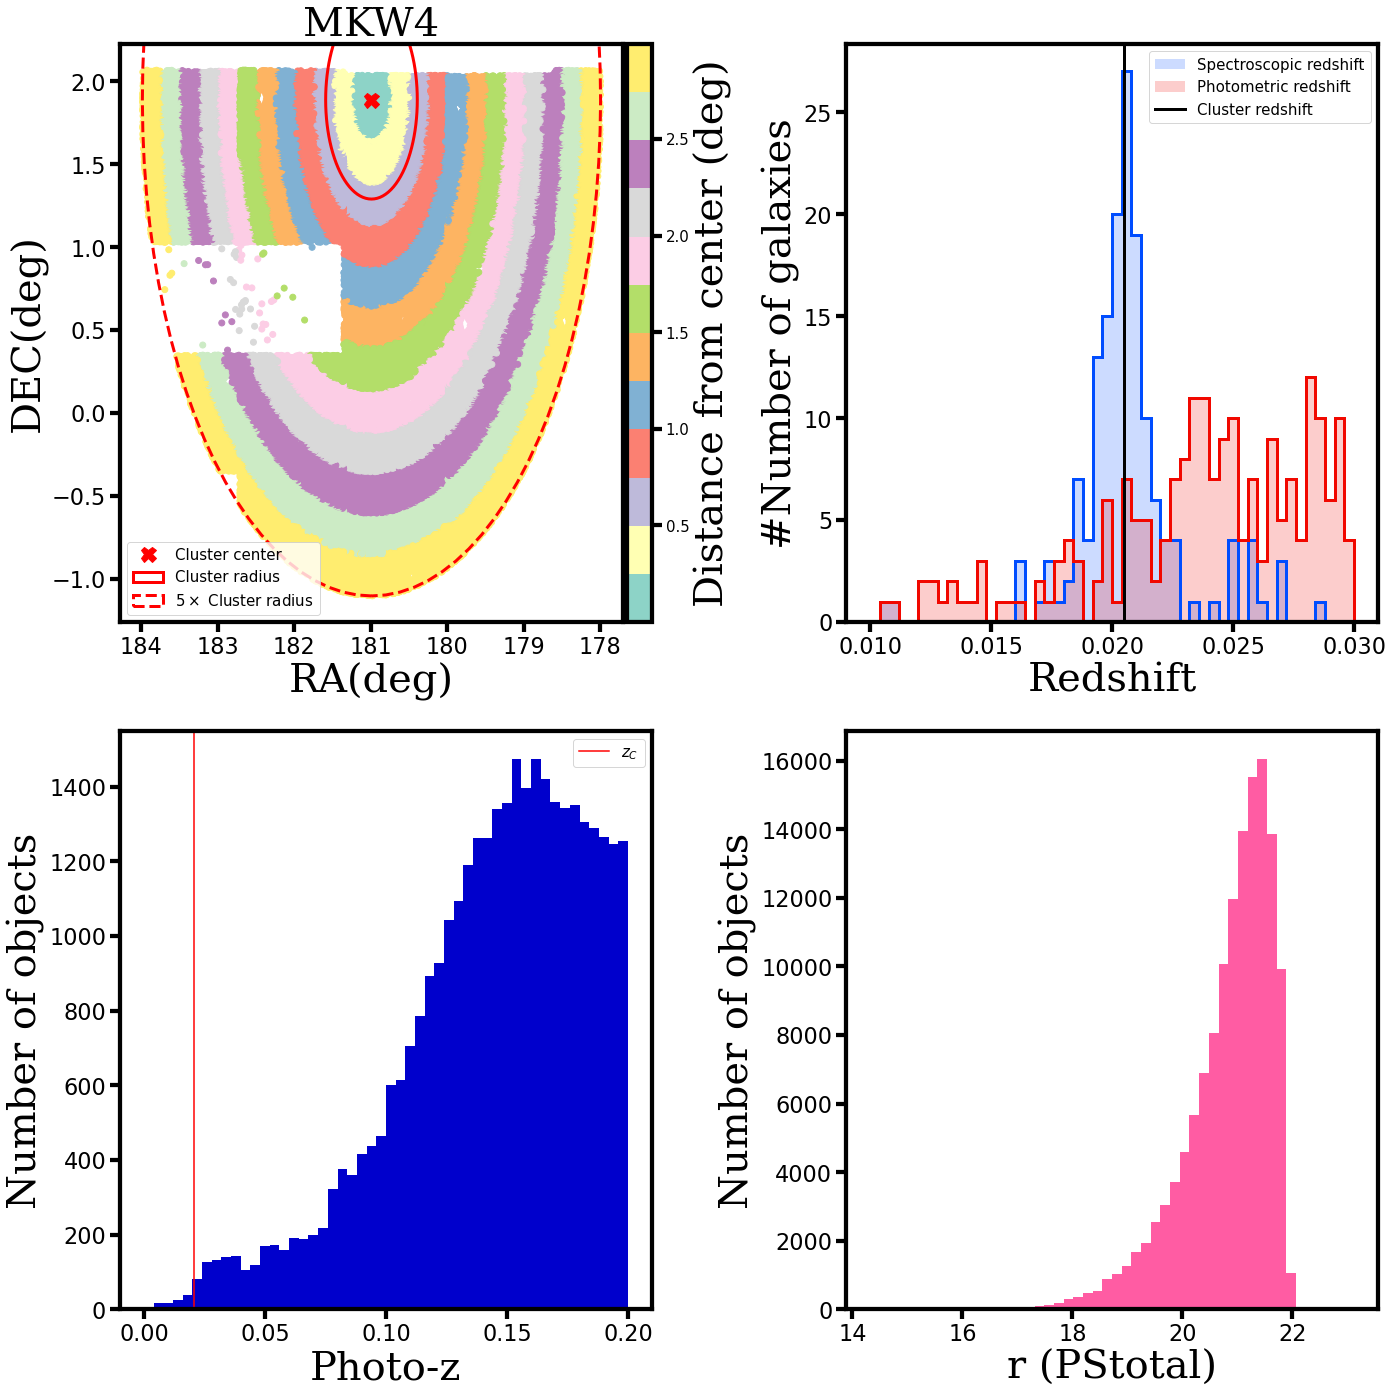

In [137]:
bins = 50
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(221)
sc1 = ax1.scatter(ra[mask_redshift][mask_cluster_region], dec[mask_redshift][mask_cluster_region], 
            marker='o', c=sep_all[mask_cluster_region], cmap=cm.Set3, rasterized=True)
ax1.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center")
ax1.set_xlabel('RA(deg)',fontdict=font)
ax1.set_ylabel('DEC(deg)',fontdict=font)
ax1.invert_xaxis()
ax1.set_title(cl_names[cluster], fontdict=font)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Distance from center (deg)", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')
r1 = SphericalCircle(c0, radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
r5 = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax1.add_patch(r1)
ax1.add_patch(r5)
ax1.legend(fontsize=15)


ax2 = fig.add_subplot(222)
ax2.hist(z[mask_redshift_specz][mask_cluster_specz], bins=50, color=colors1[1], histtype='stepfilled',
                 range=[z_lower, z_upper], alpha=0.2, label="Spectroscopic redshift")
ax2.hist(z[mask_redshift_specz][mask_cluster_specz], bins=50, color=colors1[1], histtype='step', lw=3.0,
                 range=[z_lower, z_upper])
ax2.hist(zml[mask_redshift][mask_cluster], bins=50, color=colors1[8], histtype='stepfilled',
                 range=[z_lower, z_upper], alpha=0.2, label="Photometric redshift")
ax2.hist(zml[mask_redshift][mask_cluster], bins=50, color=colors1[8], histtype='step', lw=3.0,
                 range=[z_lower, z_upper])
ax2.set_xlabel('Redshift',fontdict=font)
ax2.set_ylabel('#Number of galaxies',fontdict=font)
ax2.axvline(z_cluster, color="black", lw=3, label="Cluster redshift")
ax2.legend(fontsize=15)


ax3 = fig.add_subplot(223)
ax3.hist(zml, alpha=1.0, bins=bins, histtype='stepfilled', color=colors3[1], range=(0, 0.2))
# ax3.set_title(cl_names[cluster], fontdict=font)
ax3.set_xlabel("Photo-z", fontdict=font)
ax3.set_ylabel("Number of objects", fontdict=font)
ax3.axvline(z_cluster, color="red", label=r"$z_C$")
ax3.legend(fontsize=15)


ax4 = fig.add_subplot(224)
ax4.hist(rpstotal, alpha=1.0, bins=bins, histtype='stepfilled', color=colors3[5])
# ax4.set_title(cl_names[cluster], fontdict=font)
ax4.set_xlabel("r (PStotal)", fontdict=font)
ax4.set_ylabel("Number of objects", fontdict=font)

fig.tight_layout(pad=3.0)

# plt.savefig("../figures/clusters-membership/photoz_rPStotal_distributions_{}.png".format(cl_names[cluster]), dpi='figure', format='png')
# plt.savefig("../figures/clusters-membership/RA_DEC_zml_distribution_{}.png".format(cl_names[cluster]), dpi='figure', format='png')

## Compute "radial" membership probabilities

 - Ideia: queremos associar uma probabilidade de membership "radial" às galáxias na região do aglomerado;
 - Teremos uma probabilidade de pertencimento ao aglomerado ($P(C|R)$) e uma probabilidade de pertencimento ao campo ($P(F|R)$), onde C = cluster, F = field, R = distância projetada entre galáxia e centro do aglomerado;
 - Vamos assumir para o aglomerado (C) e campo (F) os seguintes perfis cumulativos radiais:
 
 $$
 \begin{align}
     &\Sigma_C = w_1 R^{-\alpha}\\
     &\Sigma_F = w_2
 \end{align}
 $$
 
 De tal forma que $P(C|R) \propto \Sigma_C$ e $P(F|R) \propto \Sigma_F$.
 
 - Podemos demonstrar que 
 
 $$
 w_2 = \frac{N_T - N_C(R_{max})}{\pi R^2_{max}}
 $$
 
 De forma que vão restar apenas dois parâmetros independentes ($w_1$ e $\alpha$ por exemplo)
 
- Na prática a ideia é ajustar esses dois perfis conjuntamente à distribuição cumulativa radial das galáxias no aglomerado;
- Ou seja, vou ter que pegar as distâncias das galáxias e criar a distribuição radial cumulativa delas, indo $r_c = 0$ até $r_c = 5R_{200}$ por exemplo
- O que a gente vai fitar são os perfis cumulativos, ou seja, $\Sigma_C$ e $\Sigma_F$ integradas em coordenadas polares:
  
 $$
 \begin{align}
     &\rho_C = 2 \pi \int_0^R \Sigma_C R dR = 2 \pi w_1 \frac{R^{2 - \alpha}}{2 - \alpha}\\
     &\rho_F = 2 \pi \int_0^R \Sigma_F R dR = \pi w_2 R^2 
 \end{align}
 $$
 
 - Importante: na hora de fazer o perfil cumulativo, é necessário selecionar só as galáxias dentro do volume do aglomerado, ou seja, aquelas que eu defino através dessas máscaras "mask_cluster_specz" e "mask_cluster" nos casos espectroscópico e fotométrico respectivamente

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:301: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  Hz, Rcz = np.histogram(clc_dist, bins=100, normed=True)


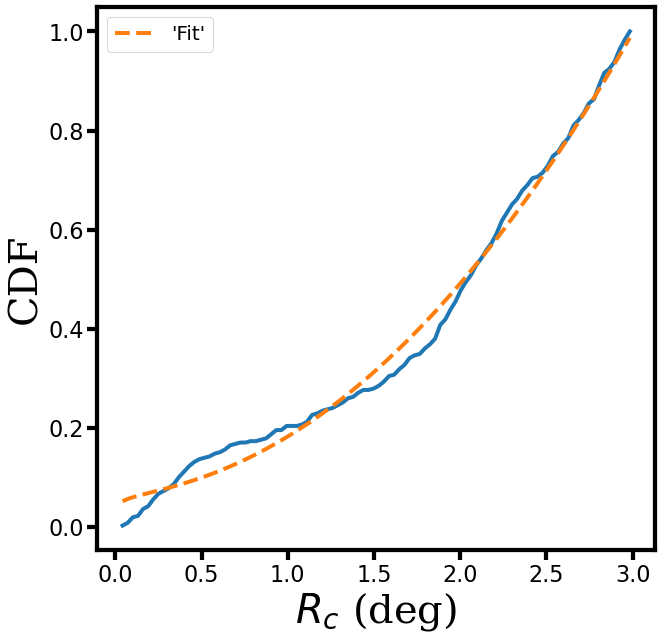

In [14]:
Pmem_R_C, Pmem_R_F = radial_mem_prob(sep_specz[mask_cluster_specz], plot=True)

## Compute priors using spectroscopic members and non-members as estimates of the number of field and cluster galaxies

$$P( g \in C) = \frac{\text{Number of spectroscopic members in the volume of the cluster}}{\text{Total number of galaxies in the volume of the cluster}}$$

In [15]:
z_members, id_members = sigma_clipping(z[mask_redshift_specz][mask_cluster_specz], objid_specz[mask_redshift_specz][mask_cluster_specz], z_lower, z_upper, 3.0)
mask_members = np.isin(objid_specz[mask_redshift_specz][mask_cluster_specz], id_members)

In [18]:
np.sum(mask_members)

132

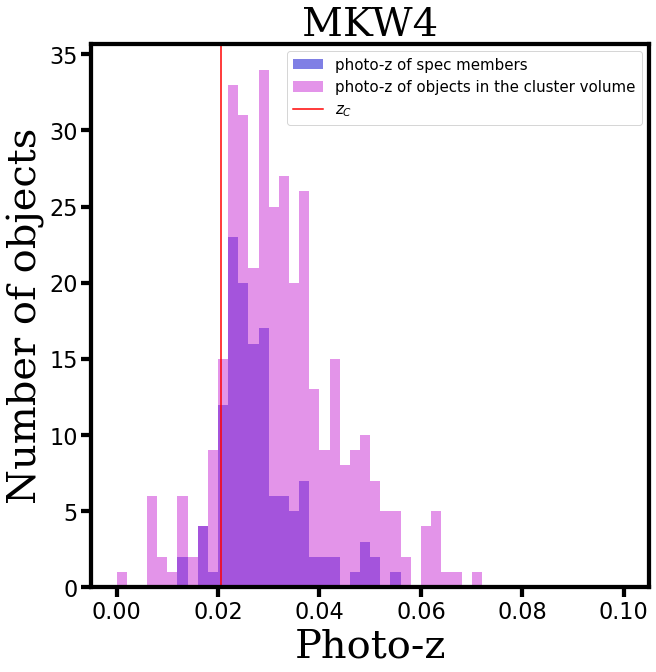

In [16]:
bins = 50
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
ax1.hist(zml_specz[mask_redshift_specz][mask_cluster_specz][mask_members], bins=bins, histtype='stepfilled', 
         color=colors3[1], alpha=0.5, label="photo-z of spec members", range=(0, 0.1))
ax1.hist(zml_specz[mask_redshift_specz][mask_cluster_specz], bins=bins, histtype='stepfilled', 
         color=colors3[4], alpha=0.5, label="photo-z of objects in the cluster volume", range=(0, 0.1))
ax1.set_title(cl_names[cluster], fontdict=font)
ax1.set_xlabel("Photo-z", fontdict=font)
ax1.set_ylabel("Number of objects", fontdict=font)
ax1.axvline(z_cluster, color="red", label=r"$z_C$")
ax1.legend(fontsize=15)

In [17]:
P_ginG = np.sum(mask_members) / np.sum(mask_cluster_specz)
P_ginF = 1 - P_ginG

print("P (g in C) = {:.3f}".format(P_ginG))
print("P (g in F) = {:.3f}".format(P_ginF))

P (g in C) = 0.369
P (g in F) = 0.631


### Compute membership probabilities for spectroscopic members to estimate purity and completeness

In [37]:
def zp_mem_prob(zps, zc, means, weights, stds, sigma):
    '''
    Compute cluster and field membership probabilities given the i-th galaxy photo-z PDF parameters

    Parameters
    ----------
    i : integer
        iteration index for the i-th galaxy

    zc : float
        cluster redshift

    means : array
        means of the photo-z PDFs

    weights : array
        weights of the photo-z PDFs

    stds : array
        standard deviations of the photo-z PDFs

    sigma : float
        width of the gaussian representing the cluster in photo-z space
    '''

    #This gaussian represents the cluster
    def gaussian(x, zc, sigma):
        y = lambda x, zc, sigma: (1 / (sigma * np.sqrt(2* np.pi))) * np.exp(-(x - zc)**2 / (2*sigma**2)) 
        a = 1 / integrate.quad(y, 0.0, np.inf, args=(zc, sigma))[0]
        return a * y(x, zc, sigma)


    P_pz_C_i_array = np.zeros(len(zps))
    P_pz_F_i_array = np.zeros(len(zps))

    for i in range(len(zps)): 
        means_ = means[i]
        weights_ = weights[i]
        stds_ = stds[i]
        
        pdfs, zmls, x = calc_PDF_series(weights_, means_, stds_) 
        
        pdfs_interp = interp1d(x, pdfs)
        a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]

        pdf_func = lambda x: a * pdfs_interp(x)
            
        if zc - 3*sigma <= 0:
            P_pz_C = integrate.quad(lambda x, sigma, zc: pdf_func(x) * gaussian(x, zc, sigma), 0.0, zc + 3*sigma, args=(sigma, zc))[0] 
            P_pz_F = integrate.quad(lambda x, sigma: pdf_func(x) / (6*sigma), 0.0, zc + 3*sigma, args=(sigma))[0]
            
        if zc - 3*sigma > 0:
            P_pz_C = integrate.quad(lambda x, sigma, zc: pdf_func(x) * gaussian(x, zc, sigma), zc - 3*sigma, zc + 3*sigma, args=(sigma, zc))[0] 
            P_pz_F = integrate.quad(lambda x, sigma: pdf_func(x) / (6*sigma), zc - 3*sigma, zc + 3*sigma, args=(sigma))[0]
        
        P_pz_C_i_array[i] = P_pz_C
        P_pz_F_i_array[i] = P_pz_F

    return P_pz_C_i_array, P_pz_F_i_array

In [38]:
P_pz_G_i_array, P_pz_F_i_array = zp_mem_prob(zml_specz[mask_redshift_specz][mask_cluster_specz], z_cluster, 
                                             pdf_means_specz.T[mask_redshift_specz][mask_cluster_specz], 
                                             pdf_weights_specz.T[mask_redshift_specz][mask_cluster_specz],
                                             pdf_stds_specz.T[mask_redshift_specz][mask_cluster_specz], sigma_specz)

/tmp/ipykernel_109223/168226457.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/tmp/ipykernel_109223/168226457.py:49: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a 

In [39]:
Pmem_pz_C = (P_pz_G_i_array * P_ginG) / (P_pz_G_i_array * P_ginG + P_pz_F_i_array * P_ginF)

In [40]:
z_members, id_members = sigma_clipping(z[mask_redshift_specz][mask_cluster_specz], objid_specz[mask_redshift_specz][mask_cluster_specz], z_lower, z_upper, 3.0)
mask_members = np.isin(objid_specz[mask_redshift_specz][mask_cluster_specz], id_members)

In [42]:
completeness = []
purity = []
d = 0.01
crit = np.arange(0.0, 1.0, d)

for c in crit:
    completeness.append(np.sum((Pmem_pz_C > c) & mask_members) / np.sum(mask_members))
    purity.append(np.sum(mask_members & (Pmem_pz_C > c)) / np.sum((Pmem_pz_C > c)))

/tmp/ipykernel_109223/3004653241.py:8: RuntimeWarning: invalid value encountered in long_scalars
  purity.append(np.sum(mask_members & (Pmem_pz_C > c)) / np.sum((Pmem_pz_C > c)))


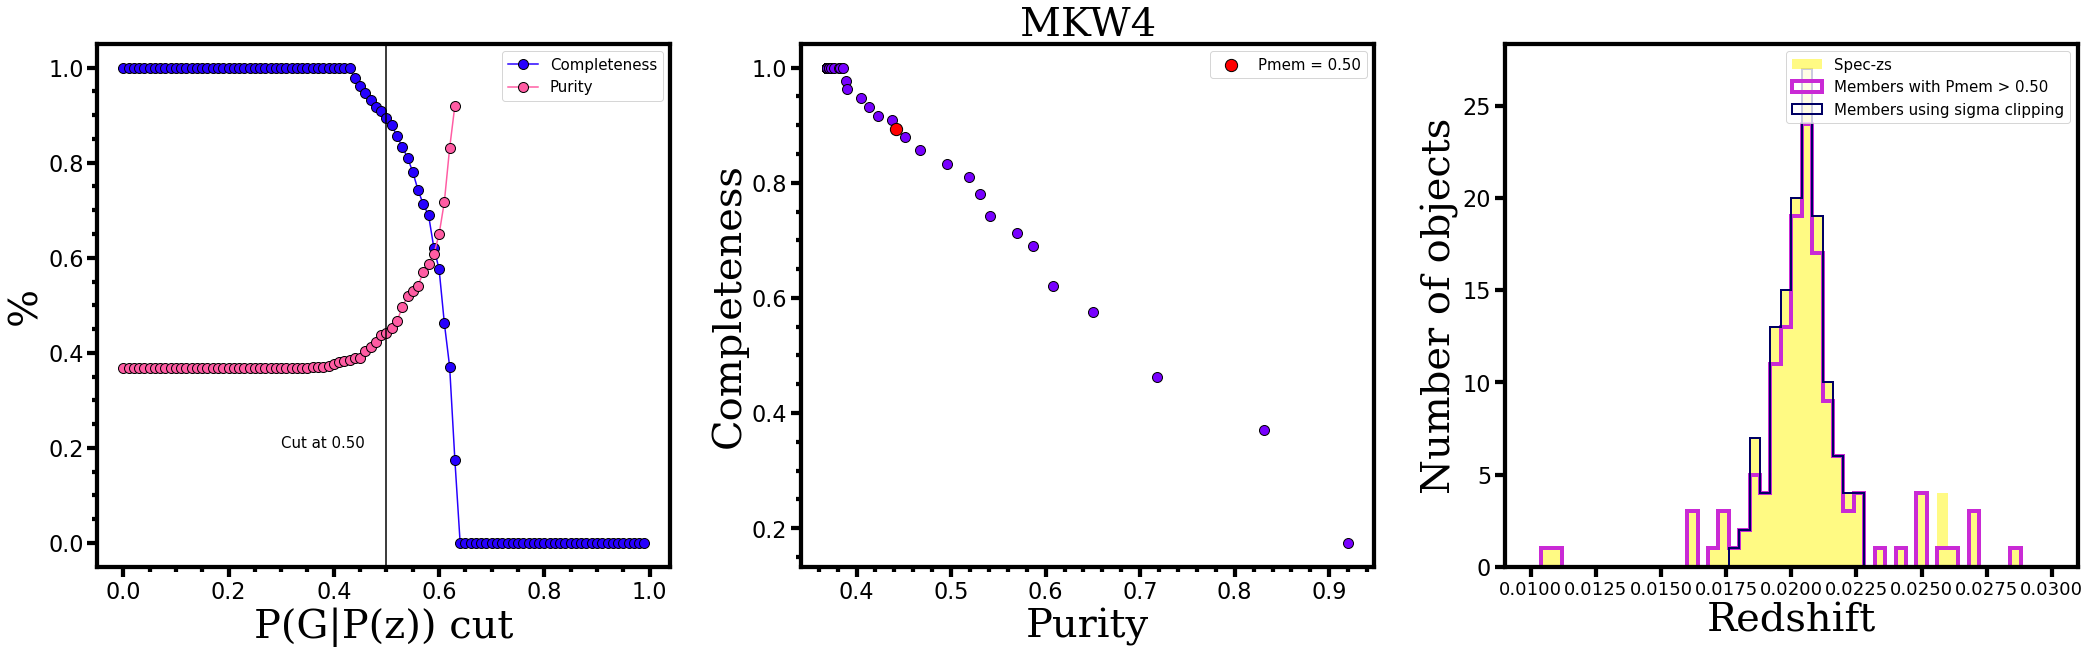

In [44]:
fig = plt.figure(figsize=(30, 10))

ax1 = fig.add_subplot(131)
ms = 10
ax1.plot(crit, completeness, marker='o', color=colors3[2], 
         label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(crit, purity, marker='o', color=colors3[5], 
         label="Purity", markersize=ms, markeredgecolor="black")

ax1.set_ylabel("%", fontdict=font)
ax1.set_xlabel("P(G|P(z)) cut", fontdict=font)
ax1.minorticks_on()

lg=plt.legend(fontsize=15)
lg.draw_frame(True)

cut = 0.50
ax1.axvline(cut, color="black")
ax1.text(x=cut-0.2, y=0.2, s="Cut at {:.2f}".format(cut), fontsize=15)
# ax1.text(x=0.03, y=0.8, s="P(g in F) = {:.2f}".format(P_ginF), fontsize=15)
# ax1.text(x=0.03, y=0.75, s="P(g in C) = {:.2f}".format(P_ginG), fontsize=15)

ax2 = fig.add_subplot(132)
ax2.scatter(purity, completeness, marker='o', color=colors3[3], s=100, edgecolor="black")

ax2.scatter(purity[np.argwhere(np.abs(crit - cut) == np.abs(crit - cut).min())[0][0]], completeness[np.argwhere(np.abs(crit - cut) == np.abs(crit - cut).min())[0][0]],
            marker='o', color="red", s=150, edgecolor="black", label="Pmem = {:.2f}".format(cut))

ax2.set_ylabel("Completeness", fontdict=font)
ax2.set_xlabel("Purity", fontdict=font)
ax2.set_title(cl_names[cluster], fontdict=font)
ax2.minorticks_on()

lg=plt.legend(fontsize=15)
lg.draw_frame(True)



ax3 = fig.add_subplot(133)
bins = 50
ax3.hist(z[mask_redshift_specz][mask_cluster_specz], alpha=0.5, label='Spec-zs', bins=bins, range=(z_lower, z_upper), 
        histtype='stepfilled', color=colors3[8])
ax3.hist(z[mask_redshift_specz][mask_cluster_specz][Pmem_pz_C > cut], alpha=1.0, label='Members with Pmem > {:.2f}'.format(cut), 
        bins=bins, range=(z_lower, z_upper), histtype='step', lw=4, color=colors3[4])
ax3.hist(z_members, alpha=1.0, label='Members using sigma clipping'.format(cut), bins=bins, range=(z_lower, z_upper), 
        histtype='step', lw=2, color=colors3[0])

ax3.set_xlabel("Redshift", fontdict=font)
ax3.set_ylabel("Number of objects", fontdict=font)

ax3.tick_params(axis='x', labelsize=18)

lg=plt.legend(fontsize=15)
lg.draw_frame(True)

fig.tight_layout(pad=4.0)

# plt.savefig("../figures/clusters-membership/purity_completeness_5R200_spec-priors_{}.png".format(cl_names[cluster]), dpi='figure', format='png')

### Complete probability

It's some combination between radial and photo-z probabilities

We have to think on a way to combine the two probabilities so that it makes sense

In [227]:
Pmem = 0.1*Pmem_R_C + 0.9*Pmem_zp_C

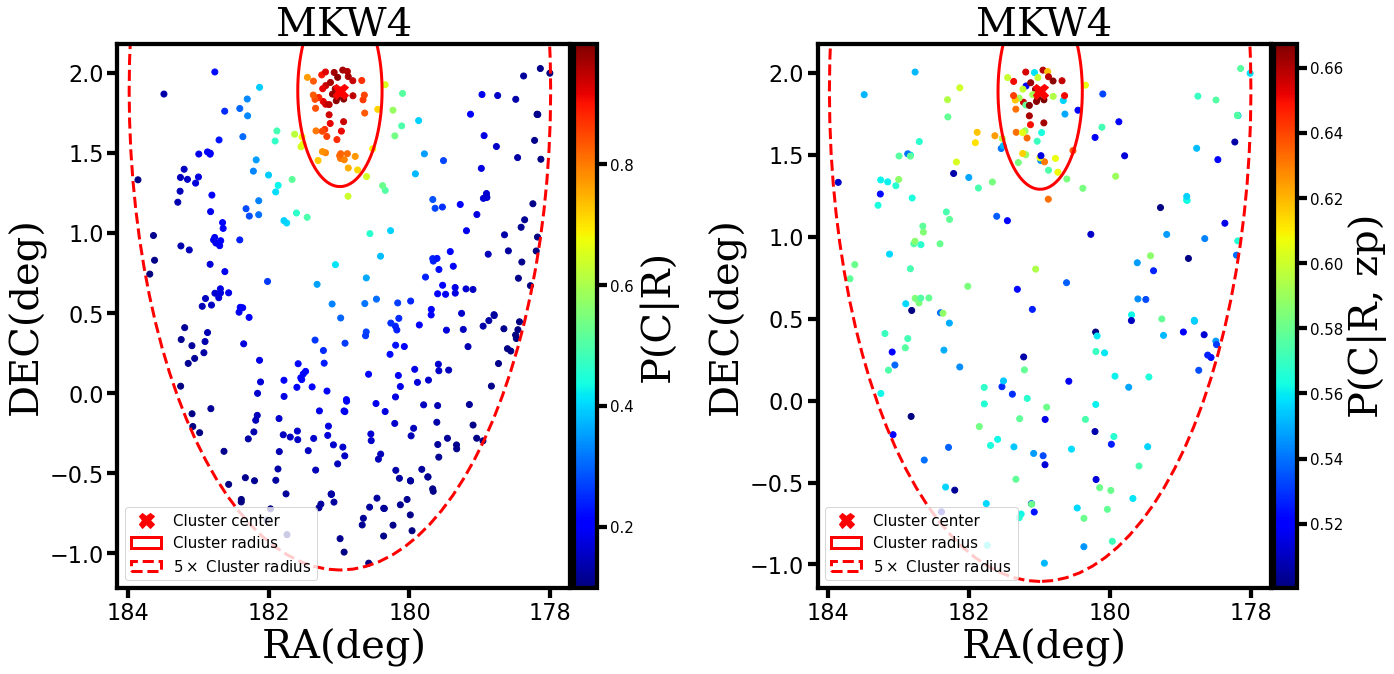

In [233]:
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121)
sc1 = ax1.scatter(ra_specz[mask_redshift_specz][mask_cluster_specz], 
                  dec_specz[mask_redshift_specz][mask_cluster_specz], 
                  marker='o', c=Pmem_R_C, cmap="jet", rasterized=True)
ax1.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center")
ax1.set_xlabel('RA(deg)',fontdict=font)
ax1.set_ylabel('DEC(deg)',fontdict=font)
ax1.invert_xaxis()
ax1.set_title(cl_names[cluster], fontdict=font)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="P(C|R)", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

r1 = SphericalCircle(c0, radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
r5 = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax1.add_patch(r1)
ax1.add_patch(r5)

ax1.legend(fontsize=labelsize)

c = 0.5
ax2 = fig.add_subplot(122)
sc2 = ax2.scatter(ra_specz[mask_redshift_specz][mask_cluster_specz][Pmem > c], 
                  dec_specz[mask_redshift_specz][mask_cluster_specz][Pmem > c], 
                  marker='o', c=Pmem[Pmem > c], cmap="jet", rasterized=True)
ax2.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center")
ax2.set_xlabel('RA(deg)',fontdict=font)
ax2.set_ylabel('DEC(deg)',fontdict=font)
ax2.invert_xaxis()
ax2.set_title(cl_names[cluster], fontdict=font)

divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc2, cax=cax2, orientation='vertical')
cbar.set_label(label="P(C|R, zp)", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

r1 = SphericalCircle(c0, radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
r5 = SphericalCircle(c0, 5*radius_cluster*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax2.add_patch(r1)
ax2.add_patch(r5)

ax2.legend(fontsize=labelsize)

fig.tight_layout(pad=3.0)

# plt.savefig("../figures/clusters-membership/RA_DEC_z_distribution_{}.png".format(cl_names[cluster]), dpi='figure', format='png')

## Apply membership to all galaxies

Os erros estão muito grandes, e eu acabo selecionando membros em um intervalo muito grande de photo-zs...

In [ ]:
Pmem = np.zeros(len(zml[mask_redshift][mask_cluster]))
for i in range(len(zml[mask_redshift][mask_cluster])):  
    P_pz_G_i, P_pz_F_i = P_pz(i, z_cluster, pdf_means.T[mask_redshift][mask_cluster], 
                              pdf_weights.T[mask_redshift][mask_cluster],
                              pdf_stds.T[mask_redshift][mask_cluster], sigma)
    Pmem[i] = (P_pz_G_i * P_ginG) / (P_pz_G_i * P_ginG + P_pz_F_i * P_ginF)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

bins = 50
ax.hist(zml[mask_redshift][mask_cluster], alpha=0.5, label='Spec-zs', bins=bins, range=(z_lower, z_upper), 
        histtype='stepfilled', color=colors3[0])
ax.hist(zml[mask_redshift][mask_cluster][Pmem > cut], alpha=1.0, label='Members with Pmem > {:.2f}'.format(cut), 
        bins=bins, range=(z_lower, z_upper), histtype='step', lw=4, color=colors3[4])

ax.set_title(cl_names[cluster], fontdict=font)
ax.set_xlabel("Photo-z", fontdict=font)
ax.set_ylabel("Number of objects", fontdict=font)

lg=plt.legend(fontsize=15)
lg.draw_frame(True)

# plt.savefig("figures/photoz_distribution_membership_{}.png".format(cl_names[cluster]), dpi='figure', format='png')

In [ ]:
final_cluster_table = t.loc[np.isin(objid, objid[mask_redshift][mask_cluster])]
final_cluster_table["Pmem"] = Pmem
final_cluster_table.to_csv("clusters-membership/table_membership_{}.csv".format(cl_names[cluster]), index=False)